Check also https://www.authorea.com/users/173169/articles/208172-october-25-2017-summary-of-individual-fish-stochastic-swimming-model-and-fitting-results

Check coordinate system.

In [1]:
%matplotlib inline
import numpy as np
import dill as pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import sys
sys.path.append('../')
from numba import jit

from scipy.optimize import minimize, least_squares, curve_fit
from scipy.integrate import quad
from scipy.stats import spearmanr
from sklearn.mixture import GaussianMixture
from calovi import WallModel, SocialModel, KickModel

np.set_printoptions(suppress=True)

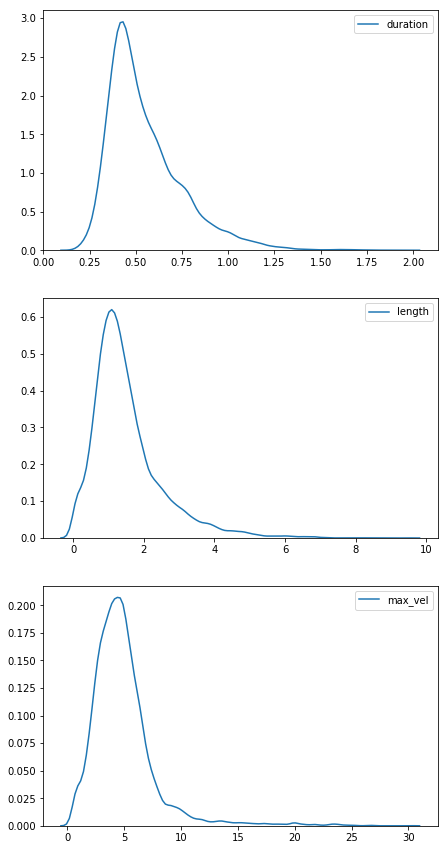

In [2]:
df = pd.read_csv("../../data/processed/kicks_guy.csv")
# TODO: Move to other notebook
fig, ax = plt.subplots(3, figsize=(5*2**(0.5), 3*5))
sns.kdeplot(df['duration'],ax=ax[0])
sns.kdeplot(df['length'], ax=ax[1])
sns.kdeplot(df['max_vel'], ax=ax[2])

fig.savefig('../../figures/kick_plots.pdf')
def fit_mixture(df, column, n_components=2):
    var = df[column].values.reshape(-1, 1)
    mix = GaussianMixture(n_components=n_components)
    mix.fit(var)
    return mix

# Create models for duration, length, max_velocity that we can sample from
duration_gmm = fit_mixture(df, 'duration')
length_gmm = fit_mixture(df, 'length')
max_vel_gmm = fit_mixture(df, 'max_vel')

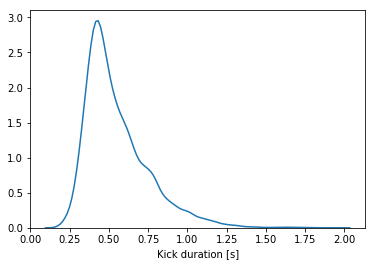

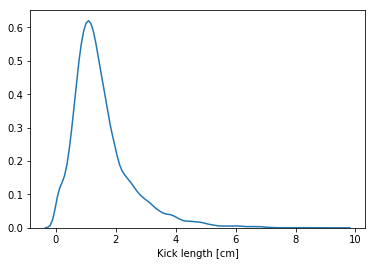

In [3]:
fig, ax = plt.subplots()
sns.kdeplot(df['duration'],ax=ax)
ax.legend_.remove()
ax.set_xlabel("Kick duration [s]")
fig.savefig('../../figures/kick_duration.pdf', transparent=True, bbox_inches='tight')

fig, ax = plt.subplots()
sns.kdeplot(df['length'],ax=ax)
ax.legend_.remove()
ax.set_xlabel("Kick length [cm]")
fig.savefig('../../figures/kick_length.pdf', transparent=True, bbox_inches='tight')

0.838382152283
0.7933600206077572


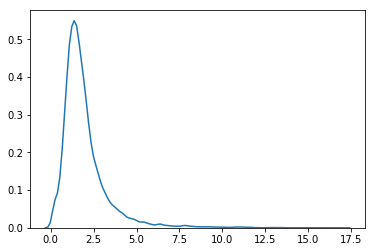

In [4]:
# Quick hack to find velocity decay parameter!
x0 = np.array([0.10])
max_vel = df['max_vel'].values
end_vel = df['end_vel'].values
length = df['length']
duration = df['duration'].values
vel_ratio = end_vel/max_vel
#decay = lambda time, decay_time: np.exp(-time/decay_time)
decay = lambda time, decay_time: np.exp(-time * decay_time)
res = curve_fit(decay, xdata=duration, ydata=vel_ratio, p0=x0)
velocity_decay_time = res[0][0]
print(velocity_decay_time)
# Check approximation of length by Calovis exponential decay model
length_hat = max_vel * velocity_decay_time * \
            (1 - np.exp(-duration/res[0]))
print(np.mean((length -  length_hat)**2))
sns.kdeplot(length_hat)

In [5]:
kick_model = KickModel(max_vel_gmm, duration_gmm, velocity_decay_time)
with open('../calovi_kick.model', 'wb') as f:
    pickle.dump(kick_model, f)
kick_model.get_peak_speed(), kick_model.get_kick_duration(), kick_model.get_velocity_decay_time()

(4.471005904224735, 0.47224523158599746, 0.83838215228289747)

In [6]:
# Find average heading change without wall influence.
threshold = 10.0 # cm
condition = (df['wall_distance0_f0'] > threshold) & (df['wall_distance1_f0'] > threshold) & \
            (df['wall_distance2_f0'] > threshold) & (df['wall_distance3_f0'] > threshold)
    
print(f"We're considering {len(df[condition])} rows.")
free_heading = df[condition]['heading_change']
(np.array([free_heading.std(), free_heading.mean()]))

We're considering 101 rows.


array([ 0.94469102,  0.06131382])

In [7]:
#df = df.drop(df[df['neighbor_distance'] < 10].index) # No kicks where fish are close
#df = df.drop(df[df['geometric_leader'] != 'f0'].index) 
#df = df.drop(df[df['fish_id'] != 'f0'].index)

df.index = np.arange(0, len(df))
#df.index = np.arange(0, len(df))
df.describe()

,heading_change,duration,gliding_duration,length,max_vel,end_vel,neighbor_distance,neighbor_angle,viewing_angle_ltf,viewing_angle_ftl,...,wall_angle2_f0,wall_angle3_f0,wall_distance0_f1,wall_distance1_f1,wall_distance2_f1,wall_distance3_f1,wall_angle0_f1,wall_angle1_f1,wall_angle2_f1,wall_angle3_f1
count,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,...,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000
mean,0.002773,0.550547,0.274196,1.529298,4.908010,3.147454,2.511966,0.035213,-0.262211,0.102274,...,-1.488806,0.102056,14.608884,15.808968,15.183330,13.614281,1.650385,0.079589,-1.491207,0.094399
std,1.071303,0.202301,0.129749,1.008839,2.882660,2.560732,1.876228,1.812353,2.104238,1.402347,...,0.914981,2.410310,9.733474,9.595792,9.733474,9.595792,0.915551,0.915551,0.915551,2.409579
min,-3.125125,0.180000,0.030000,0.000801,0.346064,-0.784682,0.340065,-3.140171,-3.141478,-3.109287,...,-3.141571,-3.141277,0.382050,0.009460,0.301460,0.066492,0.000244,-1.570552,-3.141349,-3.141407
25%,-0.291637,0.410000,0.200000,0.888736,3.213343,1.119812,1.805907,-1.498919,-2.257686,-0.964648,...,-2.181563,-2.167992,4.615877,6.426465,5.556264,3.936625,0.950613,-0.620183,-2.190980,-2.172278
50%,0.024419,0.500000,0.250000,1.293240,4.472148,2.814250,2.279094,0.001008,-0.886593,0.214016,...,-1.577378,1.579259,14.532601,16.408396,15.259614,13.014853,1.564619,-0.006177,-1.576974,1.577475
75%,0.376038,0.650000,0.300000,1.883361,5.823466,4.472666,2.811686,1.639678,1.844437,1.126179,...,-0.608222,2.541136,24.235950,25.486625,25.176338,22.996784,2.531501,0.960705,-0.610091,2.527972
max,3.124601,1.950000,1.260000,9.458592,30.068496,30.068496,30.505920,3.141156,3.141227,3.133992,...,-0.000232,3.141248,29.490754,29.356757,29.410165,29.413789,3.141532,1.570735,-0.000061,3.141570


In [8]:
# Try grad.desc as a sanity check
def calc_wall_error(model, xdata, ydata, params=None):
    lambda_reg = 0.0
    return np.linalg.norm (model(xdata) - ydata)

#fCur = lambda dist: f(dist, 1.9)
#OCur = lambda angle: O(angle, 0.8, 0.0)
#calc_wall_error(heading_change, wall_distance0, wall_angle0, fCur, OCur)

def compute_r2(x, y, model=None, yhat=None):
    if yhat is None:
        yhat = model(x)
    residuals = y - yhat
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - (ss_res/ss_tot)

In [9]:
heading_change = df['heading_change'].values
wall_distance0 = np.vstack([df[f'wall_distance{i}_f0'].values for i in range(4)])
wall_angle0 = np.vstack([-df[f'wall_angle{i}_f0'].values for i in range(4)])

# Take only closest 2 walls!
#num = 2
#idx_rows = np.argpartition(-wall_distance0, num, axis=0)[:num, :]
#idx_cols = np.arange(wall_distance0.shape[1])[None, :]
#wall_distance0 = wall_distance0[idx_rows, idx_cols]
#wall_angle0 = wall_angle0[idx_rows, idx_cols]
#print(wall_distance0.shape, wall_angle0.shape)

xdata_wall = np.vstack((wall_distance0, wall_angle0))
ydata = heading_change

# Model
angular_model = 'sin-cos'
wall_model = WallModel(angular_model)
angular = WallModel.angular_map
init_x = WallModel.params_map

eval_wall_model = lambda xdata, *params: wall_model.evaluate_raw(xdata, *params)
x0 = init_x[angular_model]

l_bounds = np.array([-np.inf] * len(x0))
u_bounds = np.array([ np.inf] * len(x0))

l_bounds[1] = 0.0 # no negative decay
#u_bounds[4] = 10e-10
#l_bounds[4] = -10e-10
bounds = (l_bounds, u_bounds)

res = curve_fit(eval_wall_model, xdata=xdata_wall, ydata=ydata, p0=x0, bounds=bounds,max_nfev=1000000)
x_opt_wall = res[0]

fitted_model = lambda xdata: eval_wall_model(xdata, *x_opt_wall)
random_model = lambda xdata: eval_wall_model(xdata, *x0)
mean_model = lambda xdata: np.ones_like(xdata) * np.mean(ydata)

print(f"Curve fit reached error of {calc_wall_error(fitted_model, xdata_wall, ydata, x_opt_wall)} with params={str(x_opt_wall)}")
print(f"1-Std-error of params is {np.sqrt(np.diag(res[1]))}")
print(f"Random params reached error of {calc_wall_error(random_model, xdata_wall, ydata, x0)} with params={x0}")

# Calculate error for mean heading change as model
mean_heading_error = calc_wall_error(mean_model, xdata_wall, ydata, np.array([0.0]))
print(f"Predicting the average heading {np.mean(ydata)} for each heading leads to an error of {mean_heading_error}")

print(f"Model has r^2 of {compute_r2(xdata_wall, ydata, fitted_model)}")
yHat = fitted_model(xdata_wall)
print(f"Correlation={np.corrcoef(ydata, yHat)[0][1]}")
print(f"{spearmanr(ydata, -fitted_model(xdata_wall))}")

wall_model.set_params(x_opt_wall)
# Save fitted model to file.
with open('../calovi_wall.model', 'wb') as file:
    pickle.dump(wall_model, file)

Curve fit reached error of 113.93518806739596 with params=[  2.60768632  19.27658519   1.7192963    0.14107879 -12.03797358
   1.00220087]
1-Std-error of params is [ 97328.22112517      0.02280303  64170.31451403   5265.5672523
      0.27934069      0.00489905]
Random params reached error of 128.23311402307309 with params=[ 1.   6.   0.7  0.   0.   0. ]
Predicting the average heading 0.0027733467445596326 for each heading leads to an error of 347.4855866015261
Model has r^2 of 0.13993327867018213
Correlation=0.37492193985312294
SpearmanrResult(correlation=-0.30056835912766955, pvalue=9.7737747250534976e-273)


In [10]:
num = 4
idx = 1200
#idx_rows = np.argpartition(wall_distance0, num, axis=0)[:num, :]
idx_rows = np.argsort(wall_distance0, axis=0)[:num, :]
idx_cols = np.arange(wall_distance0.shape[1])[None, :]
wall_distance0[idx_rows, idx_cols][:,idx], wall_distance0[:][:,idx]
#wall_angle0 = wall_angle0[idx_rows, idx_cols]
#print(wall_distance0.shape, wall_angle0.shape)

(array([  4.49660765,   7.6088215 ,  21.81442785,  25.29560662]),
 array([  4.49660765,   7.6088215 ,  25.29560662,  21.81442785]))

2.60768632126 52.097537469807186
Multiplier is 135.85403583140445


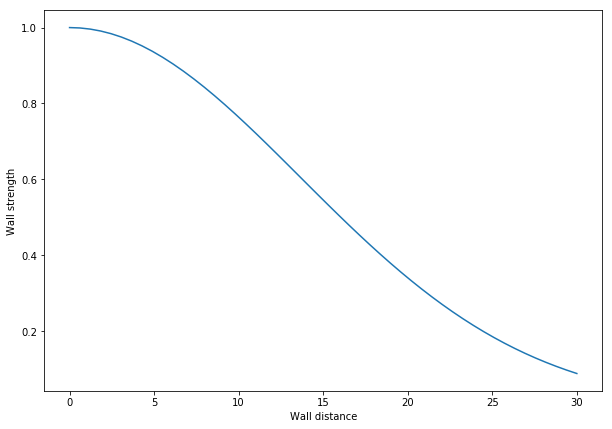

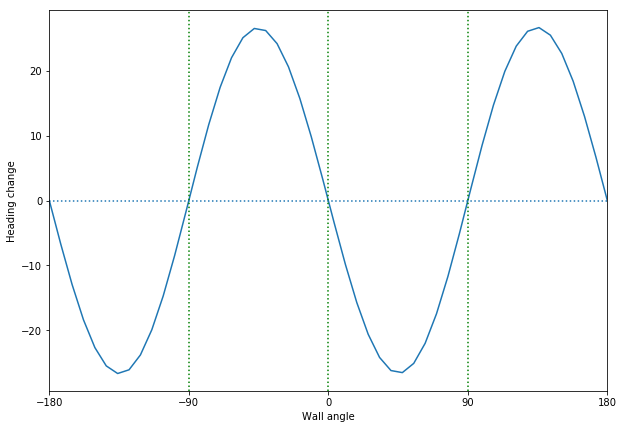

In [11]:
def get_norm_const(OCur, angles):
    return 1/(2*np.pi) * quad(lambda a: OCur(a)**2, -np.pi, np.pi)[0]

def plotFit(model):
    fCur = lambda dist: wall_model.wall_force(dist)
    OCur = lambda angle: wall_model.wall_repulsion(angle)
    norm_const = get_norm_const(OCur, np.linspace(-np.pi, np.pi))
    #norm_const = 1.0/wall_model.scale
    print(wall_model.scale, norm_const)
    print(f"Multiplier is {norm_const * wall_model.scale}")
    
    fig, ax = plt.subplots(figsize=(10,7) )    
    ax.plot(np.linspace(0, 30), fCur(np.linspace(0,30)))
    ax.set_xlabel("Wall distance")
    ax.set_ylabel("Wall strength")
    fig.savefig('../../figures/wall_force.pdf', transparent=True, bbox_inches='tight')    
       
    fig, ax = plt.subplots(figsize=(10,7) )
    ax.plot(np.rad2deg(np.linspace(-np.pi, np.pi)), OCur(np.linspace(-np.pi, np.pi))*wall_model.scale)
    plt.axhline(0, linestyle='dotted')
    ax.axvline(90, linestyle='dotted', c='g')
    ax.axvline(0.0, linestyle='dotted', c='g')
    ax.axvline(-90, linestyle='dotted', c='g')
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xlim(-180, 180)
    ax.set_xlabel("Wall angle")
    ax.set_ylabel("Heading change")
    fig.savefig('../../figures/wall_odd.pdf', transparent=True, bbox_inches='tight')
    
plotFit(wall_model)

In [12]:
df.columns

Index(['fish_id', 'heading_change', 'duration', 'gliding_duration', 'length',
       'max_vel', 'end_vel', 'neighbor_distance', 'neighbor_angle',
       'geometric_leader', 'viewing_angle_ltf', 'viewing_angle_ftl',
       'rel_orientation', 'wall_distance0_f0', 'wall_distance1_f0',
       'wall_distance2_f0', 'wall_distance3_f0', 'wall_angle0_f0',
       'wall_angle1_f0', 'wall_angle2_f0', 'wall_angle3_f0',
       'wall_distance0_f1', 'wall_distance1_f1', 'wall_distance2_f1',
       'wall_distance3_f1', 'wall_angle0_f1', 'wall_angle1_f1',
       'wall_angle2_f1', 'wall_angle3_f1'],
      dtype='object')

In [13]:
def toMin(model, x_opt_social):
    yHat = model(xdata_social, *x_opt_social)
    return np.linalg.norm(yHat - ydata)

# TODO: Drop if one wall distance is smaller than 2ish
dff = df
for i in range(4):
    #continue
    dff = dff.drop(dff[dff[f'wall_distance{i}_f0'] < 4].index)
# Data
heading_change = dff['heading_change'].values
neighbor_distance = dff['neighbor_distance']
viewing_angle = np.zeros(dff['viewing_angle_ftl'].shape)

# Angles between fish are saved w.r.t. geometric leader
fish_is_leader = dff['fish_id'] == dff['geometric_leader']
viewing_angle[fish_is_leader] = dff['viewing_angle_ltf'][fish_is_leader]
viewing_angle[~fish_is_leader] = dff['viewing_angle_ftl'][~fish_is_leader]
relative_angle = np.zeros(dff['rel_orientation'].shape)
relative_angle[fish_is_leader] = dff['rel_orientation'][fish_is_leader]
relative_angle[~fish_is_leader] = -dff['rel_orientation'][~fish_is_leader]

# Get correct xdata for wall estimation!
wall_distance0 = np.vstack([dff[f'wall_distance{i}_f0'].values for i in range(4)])
wall_angle0 = np.vstack([-dff[f'wall_angle{i}_f0'].values for i in range(4)])
xdata_wall = np.vstack((wall_distance0, wall_angle0))

xdata_social = np.vstack((neighbor_distance, viewing_angle, relative_angle))
ydata = heading_change

num_params = 2

social_model = SocialModel(num_fourier=num_params)
x0 = social_model.params
eval_social_model = lambda xdata, *params: social_model.evaluate_raw(xdata, *params)

res = curve_fit(eval_social_model, xdata=xdata_social, ydata=ydata - eval_wall_model(xdata_wall, *x_opt_wall), p0=x0)
x_opt_social = res[0]

fitted_model = lambda xdata: eval_social_model(xdata, *x_opt_social)
random_model = lambda xdata: eval_social_model(xdata, *x0)

print(f"Curve fit reached error of {toMin(eval_social_model, x_opt_social)} with params={str(x_opt_social)}")
print(f"1-Std-error of params is {np.sqrt(np.diag(res[1]))}")
print(f"Random params reached error of {toMin(eval_social_model, x0)} with params={x0}")

# Calculate error for mean heading change as model
mean_heading = np.mean(ydata)
mean_heading_error = np.sum( (ydata - mean_heading)**2 )
print(f"Predicting the average heading {mean_heading} for each heading leads to an error of {mean_heading_error}")

print(f"Model has r^2 of {compute_r2(xdata_social, ydata, fitted_model)}")
yHat = fitted_model(xdata_social)
print(f"Correlation={np.corrcoef(ydata, yHat)[0,1]}")

yHat_full = eval_social_model(xdata_social, *x_opt_social) + eval_wall_model(xdata_wall, *x_opt_wall)
print(f"Full model correlation={np.corrcoef(ydata, yHat_full)[0,1]}")
print(f"Full Model has r^2 of {compute_r2(xdata_social, ydata, yhat=yHat_full)}")

wall_model.set_params(x_opt_wall)
# Save fitted model to file.
with open('../calovi_social.model', 'wb') as file:
    pickle.dump(social_model, file)

Curve fit reached error of 46.24004278268599 with params=[  2.05898621   2.7038571    0.08044071  50.40888116   6.83539068
   0.0012598   -2.97829347   0.17735373  -0.84402921   8.10366854
  -3.84497962  -0.05130075  -0.05665337   1.        ]
1-Std-error of params is [ inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf]
Random params reached error of 127.87206871187948 with params=[ 0.3  2.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1. ]
Predicting the average heading 0.011673720032995674 for each heading leads to an error of 2421.848886927205
Model has r^2 of 0.11714493497673839
Correlation=0.36886748355969334
Full model correlation=0.4404753292407761
Full Model has r^2 of 0.18069536998871494


/home/lukas/bin/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


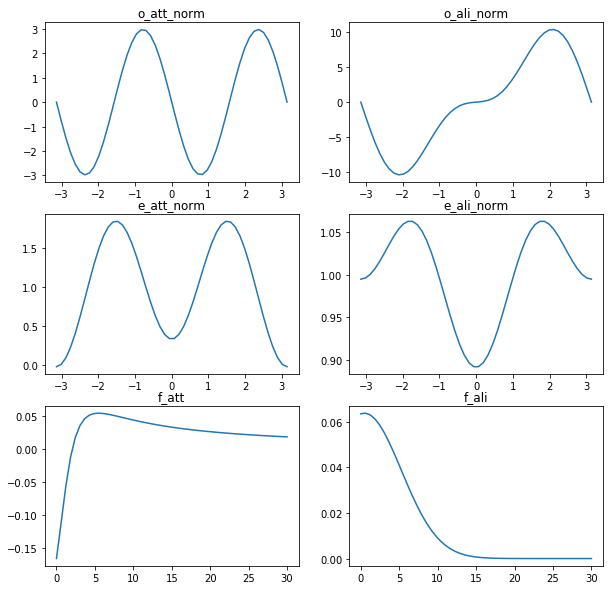

In [14]:
def get_norm_const(function, parameters):
    '''Normalizing factor s.t. square integral over -pi/pi is 1'''
    return 1/(2*np.pi) * quad(lambda a: function(a, *parameters)**2, -np.pi, np.pi)[0]

def eval_norm_func(function, parameters, angles):
    '''Evaluate a normalized angular function.
    Useful for plotting'''
    norm_const = get_norm_const(function, parameters)
    norm_const = 1.0
    return function(angles, *parameters) / norm_const

def get_params_slice(num_fun):
    '''Helper function for social model.
    TODO: Refactor this stuff out.'''
    params = x_opt_social
    offset = 5 + num_fun * num_params
    return params[offset:offset+num_params]

fig, ax = plt.subplots(3,2, figsize=(10,10))
x = np.linspace(-np.pi, np.pi)
#norm_factor = get_norm_const(o_att, get_params_slice(0)) * get_norm_const(e_att, get_params_slice(1))
ax[0][0].plot(x, social_model.o_att(x), label='o_att_norm')
ax[0][0].set_title("o_att_norm")
ax[1][0].plot(x, social_model.e_att(x), label='e_att_norm')
ax[1][0].set_title("e_att_norm")

ax[0][1].plot(x, social_model.o_ali(x), label='o_ali_norm')
ax[0][1].set_title("o_ali_norm")
ax[1][1].plot(x, social_model.e_ali(x), label='e_ali_norm')
ax[1][1].set_title("e_ali_norm")

x = np.linspace(0, 30)
ax[2][0].plot(x, social_model.f_att(x), label='f_att')
ax[2][0].set_title("f_att")
ax[2][1].plot(x, social_model.f_ali(x), label='f_ali')
ax[2][1].set_title("f_ali")

#fig.savefig("../../figures/social_4_fourier.pdf", bbox_inches='tight')